# Подготовка датасета для идентификации человека по сигналу ЭКГ

In [2]:
%matplotlib inline

# Импорт необходимых библиотек и модулей

In [3]:
# Импортирование модуля для работы с операционной системой
import sys
import os

# Импортирование типовой аннотации List из модуля typing
from typing import List

# Импортирование необходимых библиотек и модулей для анализа сигналов и построения графиков
import antropy
import biosppy
import matplotlib.pyplot as plt
import numpy as np
import wfdb



In [ ]:
from pathlib import Path

# Получаем путь до корня проекта
project_root = Path.cwd().parent  # Переходим на уровень выше от текущей директории

# Добавляем корень проекта в PYTHONPATH
sys.path.append(str(project_root))

# Проверяем, что всё работает
print(f"Добавлено в PYTHONPATH: {project_root}")



In [ ]:
# Импортирование пользовательских модулей из проекта
from src.features.mfcc import mfcc
from src.model.descriptor import Descriptor
from src.utils import const

print("Импорты завершены успешно!")


Импорты завершены успешно!


### Указываем пути к файлам

In [9]:
# Определение абсолютного пути к директории 'dataset'
DATASET_PATH = os.path.abspath(
    os.path.join('..', 'dataset')
)

# Определение абсолютного пути к поддиректории 'ecg-id-database-1.0.0' внутри 'dataset'
ECG_ID_DATASET_PATH = os.path.abspath(
    os.path.join(DATASET_PATH, 'ecg-id-database-1.0.0')
)

# Функция для получения путей к директориям, содержащим данные конкретных пользователей
def get_person_pathes(dataset_path: str) -> List[str]:
    res = []  # Инициализация пустого списка для хранения путей

    # Перебор всех элементов в директории dataset_path
    for entry in os.listdir(dataset_path):
        path = os.path.join(dataset_path, entry)  # Определение полного пути к элементу
        if os.path.isdir(path) and entry.startswith('Person_'):  # Проверка, является ли элемент директорией и начинается ли его имя с 'Person_'
            res.append(path)  # Добавление пути к директории в список

    return res  # Возвращение списка путей

# Получение путей к директориям данных конкретных пользователей из базы данных ECG-ID
PERSON_PATHES = get_person_pathes(ECG_ID_DATASET_PATH)

if not os.path.exists(ECG_ID_DATASET_PATH):
    raise FileNotFoundError(f"Путь '{ECG_ID_DATASET_PATH}' не найден!")

print(f"Содержимое директории: {os.listdir(ECG_ID_DATASET_PATH)}")

PERSON_PATHES = get_person_pathes(ECG_ID_DATASET_PATH)
print(f"Пути к директориям: {PERSON_PATHES}")


Содержимое директории: ['ANNOTATORS', 'biometric.shtml', 'Person_01', 'Person_02', 'Person_03', 'Person_04', 'Person_05', 'Person_06', 'Person_07', 'Person_08', 'Person_09', 'Person_10', 'Person_11', 'Person_12', 'Person_13', 'Person_14', 'Person_15', 'Person_16', 'Person_17', 'Person_18', 'Person_19', 'Person_20', 'Person_21', 'Person_22', 'Person_23', 'Person_24', 'Person_25', 'Person_26', 'Person_27', 'Person_28', 'Person_29', 'Person_30', 'Person_31', 'Person_32', 'Person_33', 'Person_34', 'Person_35', 'Person_36', 'Person_37', 'Person_38', 'Person_39', 'Person_40', 'Person_41', 'Person_42', 'Person_43', 'Person_44', 'Person_45', 'Person_46', 'Person_47', 'Person_48', 'Person_49', 'Person_50', 'Person_51', 'Person_52', 'Person_53', 'Person_54', 'Person_55', 'Person_56', 'Person_57', 'Person_58', 'Person_59', 'Person_60', 'Person_61', 'Person_62', 'Person_63', 'Person_64', 'Person_65', 'Person_66', 'Person_67', 'Person_68', 'Person_69', 'Person_70', 'Person_71', 'Person_72', 'Person

In [10]:
# Функция для получения путей к записям данных конкретного пользователя
def get_record_pathes(person_path):
    # Создание списка путей к записям, используя функции map и filter
    paths = list(
        map(  # Преобразование пути к записи с помощью lambda-функции
            lambda path: os.path.join(  # Создание полного пути к записи
                person_path,
                path[:-4],  # Удаление последних 4 символов из имени файла (предполагается, что это расширение файла)
            ),
            list(  # Создание списка файлов в директории person_path, отфильтрованных по расширению '.atr'
                filter(
                    lambda path: path.endswith('.atr'),  # Проверка, заканчивается ли имя файла на '.atr'
                    os.listdir(person_path)  # Получение списка всех файлов в директории person_path
                )
            )
        )
    )

    return paths  # Возвращение списка путей к записям


## Анализ записи ЭКГ

In [11]:
# Функция для получения записи данных
def get_record(record_path):
    # Чтение семплов данных из файла с использованием библиотеки wfdb
    # Указываем, что нужно читать только канал с индексом 1
    samples: np.ndarray = wfdb.rdsamp(record_path, channels=[1])[0]

    return samples  # Возвращаем массив семплов


In [12]:
# Функция для получения пиков (R-зубцов) из записи ЭКГ
def get_peaks(record):
    # Используем метод engzee_segmenter из библиотеки biosppy для нахождения пиков в сигнале ЭКГ
    # Параметры: signal - сам сигнал, sampling_rate - частота дискретизации, взятая из констант
    return biosppy.signals.ecg.engzee_segmenter(signal=record, sampling_rate=const.SAMPLING_RATE).as_dict()['rpeaks']
    # Функция возвращает словарь, из которого извлекаются значения R-зубцов (rpeaks)


In [13]:
# Функция для построения графика записи ЭКГ с отмеченными R-пиками
def plot_record(record, peaks_x):
    # Создание фигуры и оси с заданными размерами
    fig, ax = plt.subplots(figsize=(30, 10), frameon=False)
    # Удаление рамки вокруг графика
    for spine in plt.gca().spines.values():
        spine.set_visible(False)
    fig.set_facecolor((0, 0, 0, 0))  # Установка прозрачного фона для фигуры
    ax.set_facecolor((0, 0, 0, 0))  # Установка прозрачного фона для оси

    # Определение размеров шрифтов для различных элементов графика
    SMALL_SIZE = 14
    MEDIUM_SIZE = 16
    BIGGER_SIZE = 32
    plt.rc('font', size=SMALL_SIZE)  # Размер шрифта для текста
    plt.rc('axes', titlesize=SMALL_SIZE)  # Размер шрифта для заголовков осей
    plt.rc('axes', labelsize=MEDIUM_SIZE)  # Размер шрифта для подписей осей
    plt.rc('xtick', labelsize=SMALL_SIZE)  # Размер шрифта для меток на оси X
    plt.rc('ytick', labelsize=SMALL_SIZE)  # Размер шрифта для меток на оси Y
    plt.rc('legend', fontsize=SMALL_SIZE)  # Размер шрифта для легенды
    plt.rc('figure', titlesize=BIGGER_SIZE)  # Размер шрифта для заголовка фигуры

    # Установка заголовка фигуры
    fig.suptitle('Запись с R-пиками')

    # Установка меток на оси Y и диапазона оси X
    plt.yticks([-1., .0, 1.])
    plt.xlim([-100., 5_000.])
    plt.ylim([-1.1, 1.1])  # Установка диапазона оси Y
    plt.xlabel('Время')  # Подпись для оси X
    plt.ylabel('Значение сигнала')  # Подпись для оси Y

    # Получение цветовой карты для графиков
    base_colors = plt.cm.get_cmap('Set2')

    # Построение горизонтальной линии и основного сигнала
    plt.axhline(linestyle='dashed', linewidth=1, color=base_colors.colors[0])
    plt.plot(record, label='Сигнал', color=base_colors.colors[2])

    # Получение значений амплитуд R-пиков
    peaks_y = [record[peak] for peak in peaks_x]
    # Отображение R-пиков на графике
    plt.scatter(peaks_x, peaks_y, label='R-пик', color=base_colors.colors[1])

    # Добавление легенды на график
    plt.legend(loc='lower center', frameon=True)


In [14]:
# Получение путей к записям данных для первого пользователя из списка PERSON_PATHES
record_pathes = get_record_pathes(PERSON_PATHES[0])


C:\Users\user\AppData\Local\Temp\ipykernel_19460\127903079.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  base_colors = plt.cm.get_cmap('Set2')


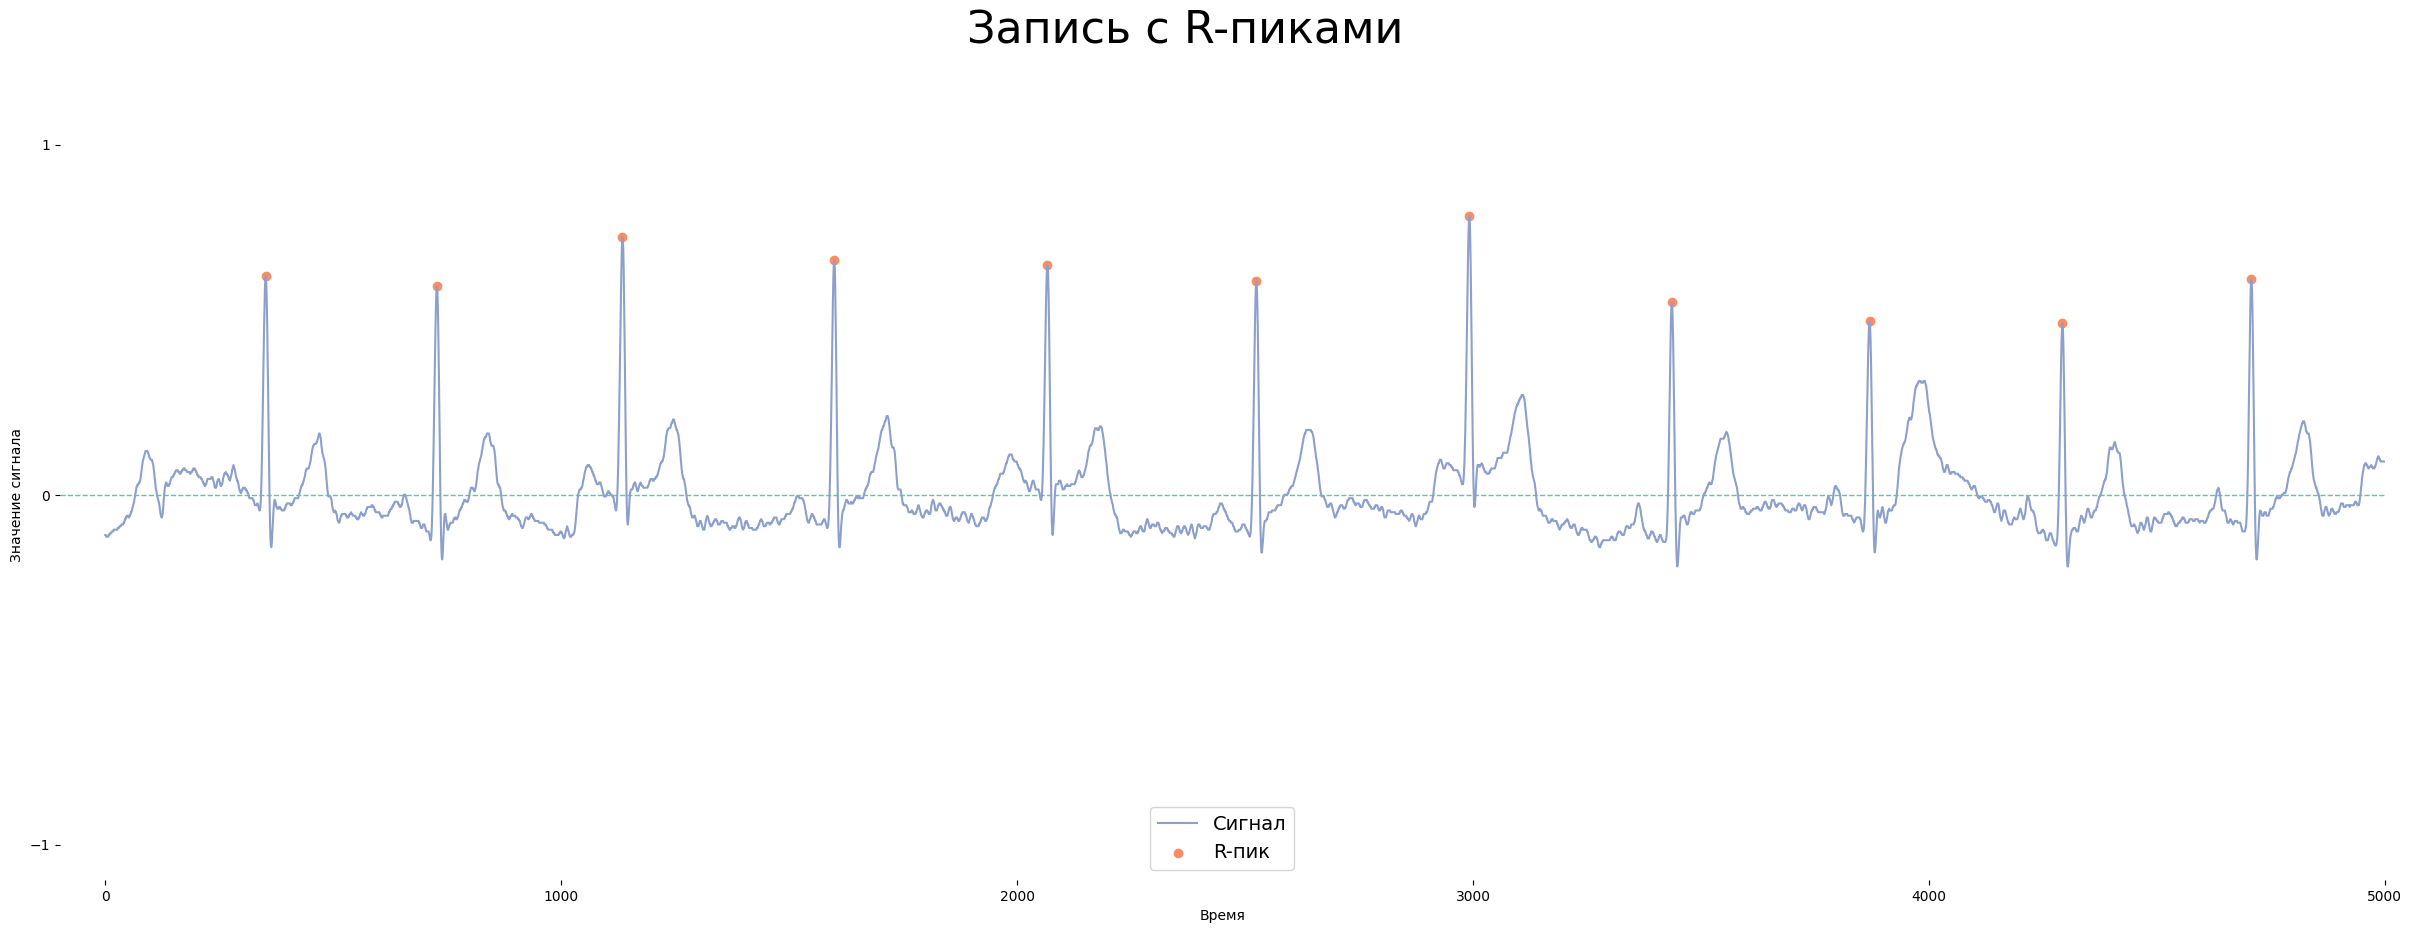

In [15]:
# Получение данных записи для первого пути из списка record_pathes
record = get_record(record_pathes[0])

# Получение R-пиков из записи
peaks = get_peaks(record)

# Построение графика записи с отмеченными R-пиками
plot_record(record, peaks)


In [33]:
def select_segments(record, peaks):
    """
    Разделение сигнала на сегменты на основе R-пиков.

    :param record: Исходный сигнал.
    :param peaks: Массив индексов R-пиков.
    :return: Список сырых сегментов и индексы самого длинного и самого короткого сегментов.
    """
    select_raw_segments = []  # Инициализация списка для сырых сегментов
    select_segment_lengths = []  # Инициализация списка для длин сегментов

    # Создание сегментов между пиками
    for i in range(len(peaks) - 1):  # Используем все пики, кроме последнего
        start = peaks[i]
        end = peaks[i + 1]
        select_raw_segments.append(record[start:end])
        select_segment_lengths.append(end - start)
        print(f"Segment {i}: Start={start}, End={end}, Length={end - start}")

    # Добавление "хвоста" сигнала, если он есть
    if peaks[-1] < len(record):
        select_raw_segments.append(record[peaks[-1]:])
        select_segment_lengths.append(len(record) - peaks[-1])
        print(f"Tail Segment: Start={peaks[-1]}, End={len(record)}, Length={len(record) - peaks[-1]}")

    # Нахождение индексов самого длинного и самого короткого сегментов
    select_longest_segment_i = np.argmax(select_segment_lengths)
    select_shortest_segment_i = np.argmin(select_segment_lengths)

    # Отладочная информация
    print("Segment lengths:", select_segment_lengths)
    print(f"Longest segment index: {select_longest_segment_i}, Length: {select_segment_lengths[select_longest_segment_i]}")
    print(f"Shortest segment index: {select_shortest_segment_i}, Length: {select_segment_lengths[select_shortest_segment_i]}")

    return select_raw_segments, select_longest_segment_i, select_shortest_segment_i

In [34]:
def plot_single_segment(segment, segment_index):
    """
    Визуализация отдельного сегмента.

    :param segment: Массив значений сигнала для одного сегмента.
    :param segment_index: Индекс сегмента (для подписи графика).
    """
    plt.figure(figsize=(10, 5))
    
    # График сегмента
    plt.plot(segment, label=f"Segment {segment_index + 1}", color="blue", alpha=0.7)
    
    plt.title(f"Segment {segment_index + 1} (Length: {len(segment)})")
    plt.xlabel("Sample Index")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.show()

In [67]:
def plot_segments(select_raw_segments):
    """
    Визуализация исходного сигнала и всех сегментов с легендой под графиком.

    :param select_raw_segments: Список сырых сегментов.
    """
    plt.figure(figsize=(15, 8))

    # График всех сегментов
    plt.subplot(2, 1, 2)
    current_sample = 0
    for i, segment in enumerate(select_raw_segments):
        segment_length = len(segment)
        plt.plot(range(current_sample, current_sample + segment_length), segment, label=f"Segment {i + 1}", alpha=0.7)
        current_sample += segment_length

    plt.title("All Segments")
    plt.xlabel("Sample Index")
    plt.ylabel("Amplitude")

    # Перемещение легенды под график
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4, fontsize=8, frameon=False)  # ncol=4 для компактности

    plt.tight_layout()
    plt.show()

    
    


In [61]:
import math

def plot_segments_in_grid(select_raw_segments):
    """
    Визуализация сегментов в сетке 3 на ряд.

    :param select_raw_segments: Список сырых сегментов.
    """
    num_segments = len(select_raw_segments)
    cols = 3  # Количество графиков в ряду
    rows = math.ceil(num_segments / cols)  # Вычисляем количество строк

    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
    axes = axes.flatten()  # Разворачиваем массив осей в одномерный для удобства

    for i, segment in enumerate(select_raw_segments):
        axes[i].plot(segment, label=f"Segment {i + 1}", color="blue", alpha=0.7)
        axes[i].set_title(f"Segment {i + 1} (Length: {len(segment)})")
        axes[i].set_xlabel("Sample Index")
        axes[i].set_ylabel("Amplitude")
        axes[i].legend()

    # Отключаем пустые оси, если сегментов меньше, чем ячеек сетки
    for j in range(num_segments, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()  # Упорядочиваем всё красиво
    plt.show()




In [59]:
def plot_all_segments_same_scale(select_raw_segments):
    """
    Визуализирует все сегменты на одном графике с одинаковым масштабом.
    
    :param select_raw_segments: Список сегментов данных (например, временные ряды или массивы).
    """
    # Вычисление общего масштаба для всех сегментов
    all_values = [value for segment in select_raw_segments for value in segment]
    min_value = min(all_values)
    max_value = max(all_values)
    
    plt.figure(figsize=(15, 6))
    
    # Отображение каждого сегмента
    for idx, segment in enumerate(select_raw_segments):
        plt.plot(segment, label=f"Segment {idx + 1} (Length: {len(segment)})", alpha=0.7)
    
    # Настройка графика
    plt.title("All Segments (Same Scale)")
    plt.xlabel("Sample Index")
    plt.ylabel("Amplitude")
    plt.ylim(min_value, max_value)  # Установка одинакового масштаба для всех сегментов
    plt.legend(loc="upper right", bbox_to_anchor=(1.15, 1), fontsize=8)  # Легенда справа от графика
    plt.tight_layout()
    plt.show()



Segment 0: Start=352, End=727, Length=375
Segment 1: Start=727, End=1134, Length=407
Segment 2: Start=1134, End=1599, Length=465
Segment 3: Start=1599, End=2066, Length=467
Segment 4: Start=2066, End=2525, Length=459
Segment 5: Start=2525, End=2992, Length=467
Segment 6: Start=2992, End=3436, Length=444
Segment 7: Start=3436, End=3870, Length=434
Segment 8: Start=3870, End=4293, Length=423
Segment 9: Start=4293, End=4707, Length=414
Segment 10: Start=4707, End=5118, Length=411
Segment 11: Start=5118, End=5497, Length=379
Segment 12: Start=5497, End=5865, Length=368
Segment 13: Start=5865, End=6224, Length=359
Segment 14: Start=6224, End=6587, Length=363
Segment 15: Start=6587, End=6958, Length=371
Segment 16: Start=6958, End=7347, Length=389
Segment 17: Start=7347, End=7735, Length=388
Segment 18: Start=7735, End=8136, Length=401
Segment 19: Start=8136, End=8545, Length=409
Segment 20: Start=8545, End=8972, Length=427
Segment 21: Start=8972, End=9397, Length=425
Segment 22: Start=9397,

C:\Users\user\AppData\Local\Temp\ipykernel_19460\127903079.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  base_colors = plt.cm.get_cmap('Set2')


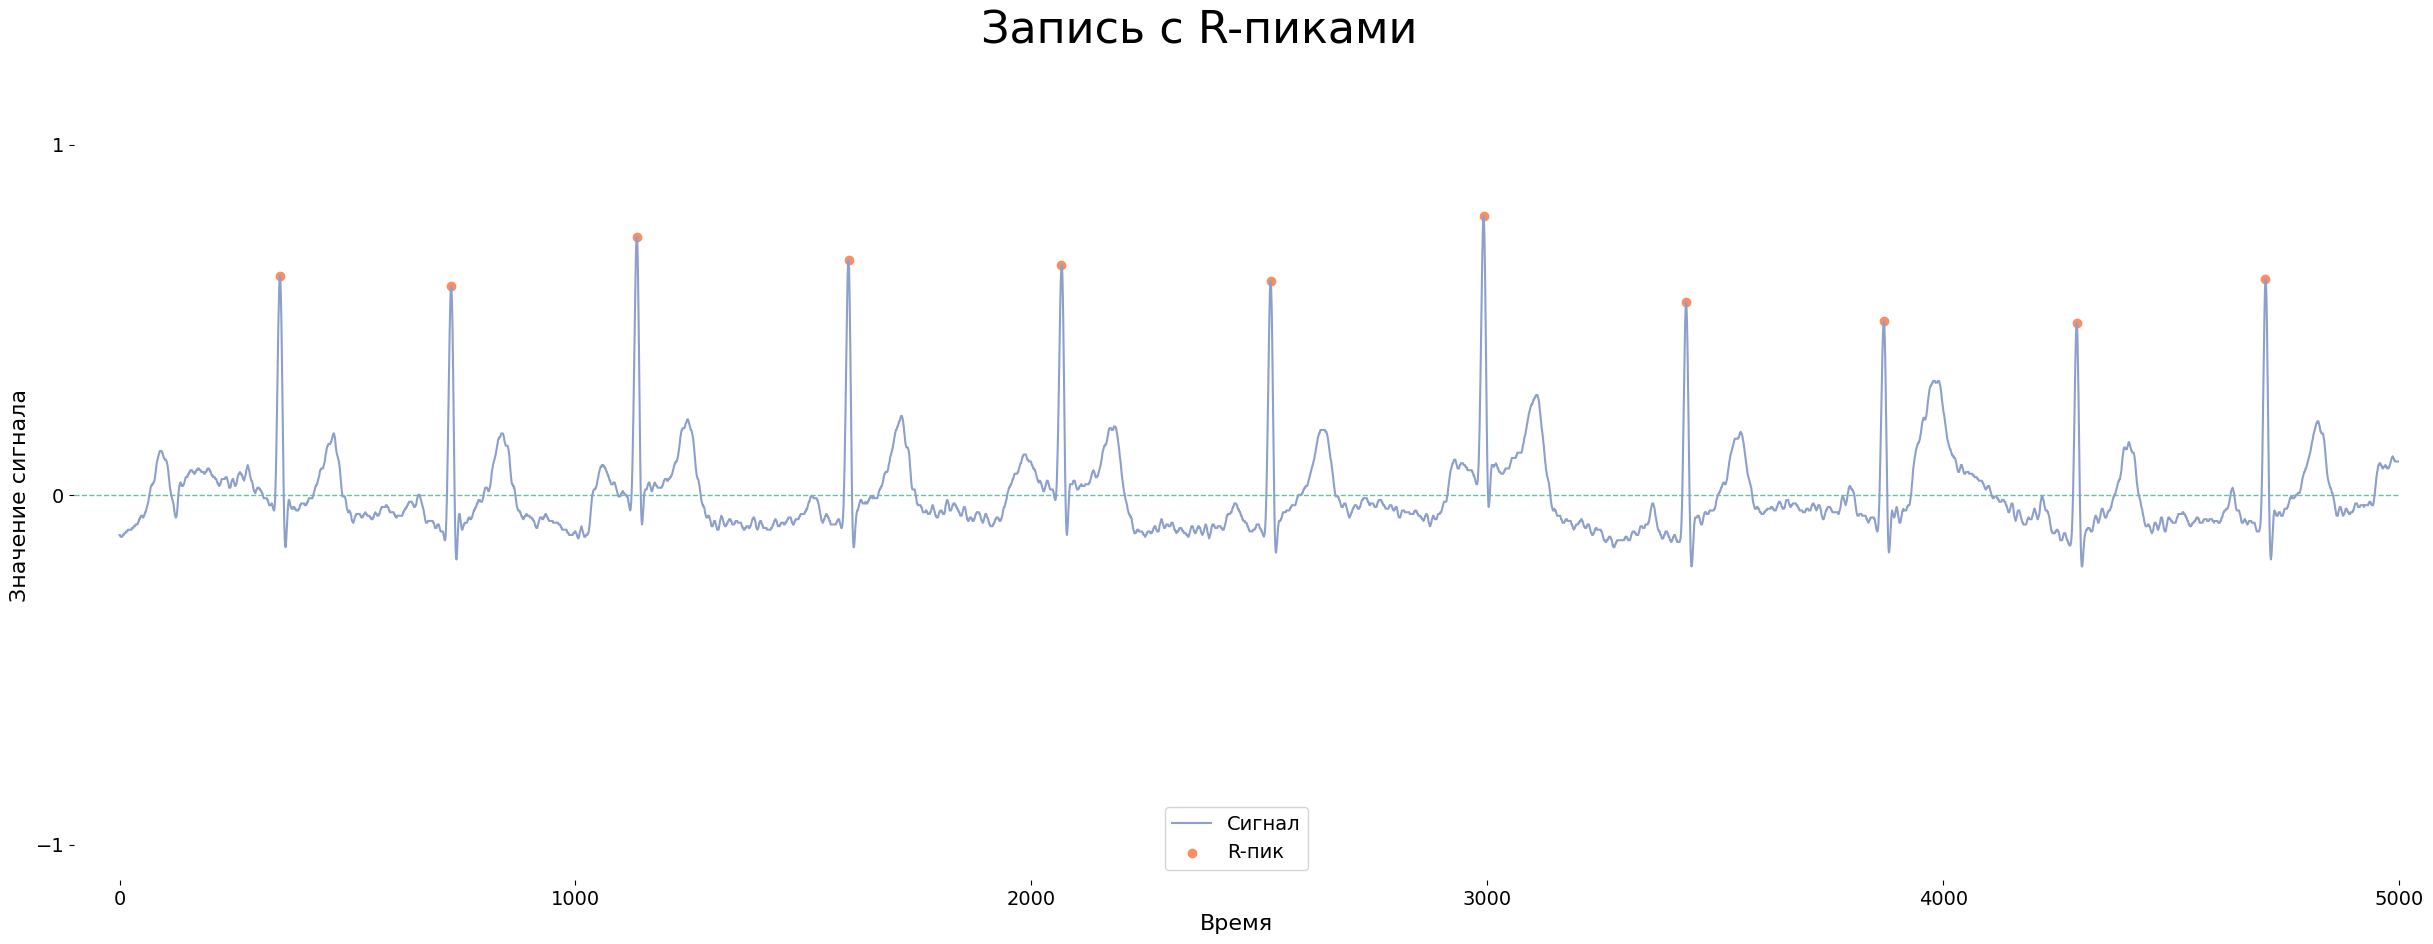

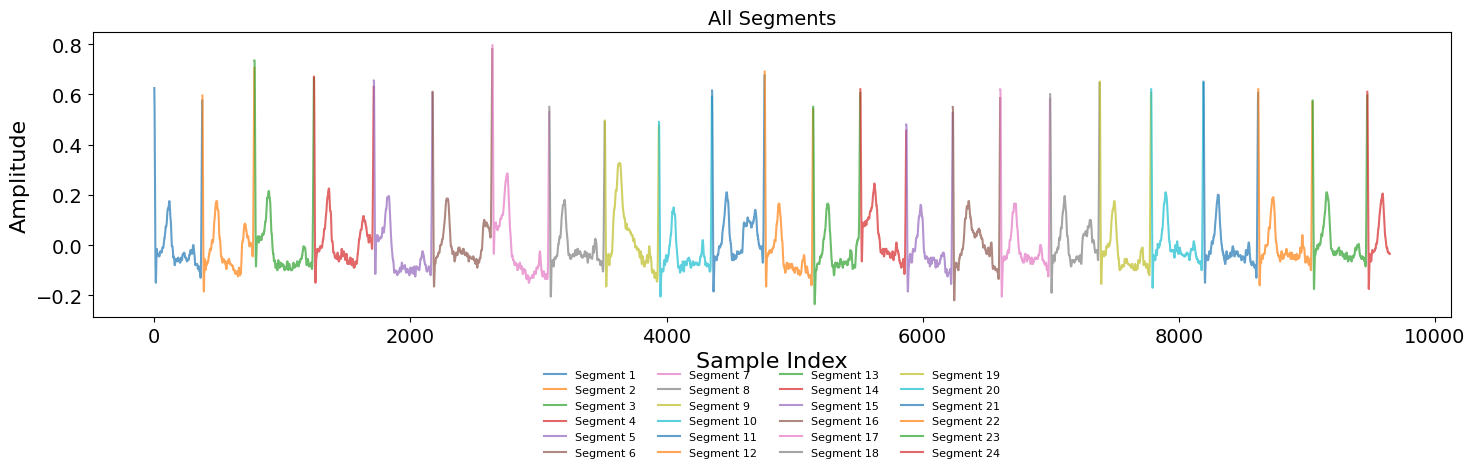

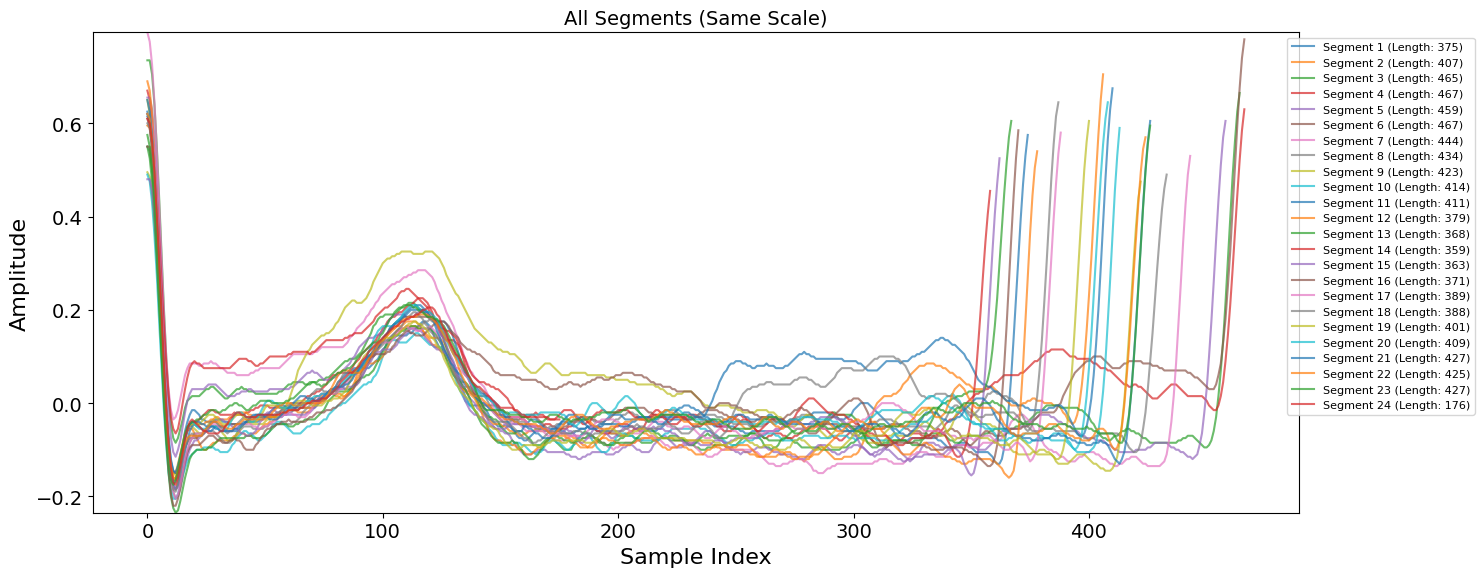


Visualizing all segments separately:


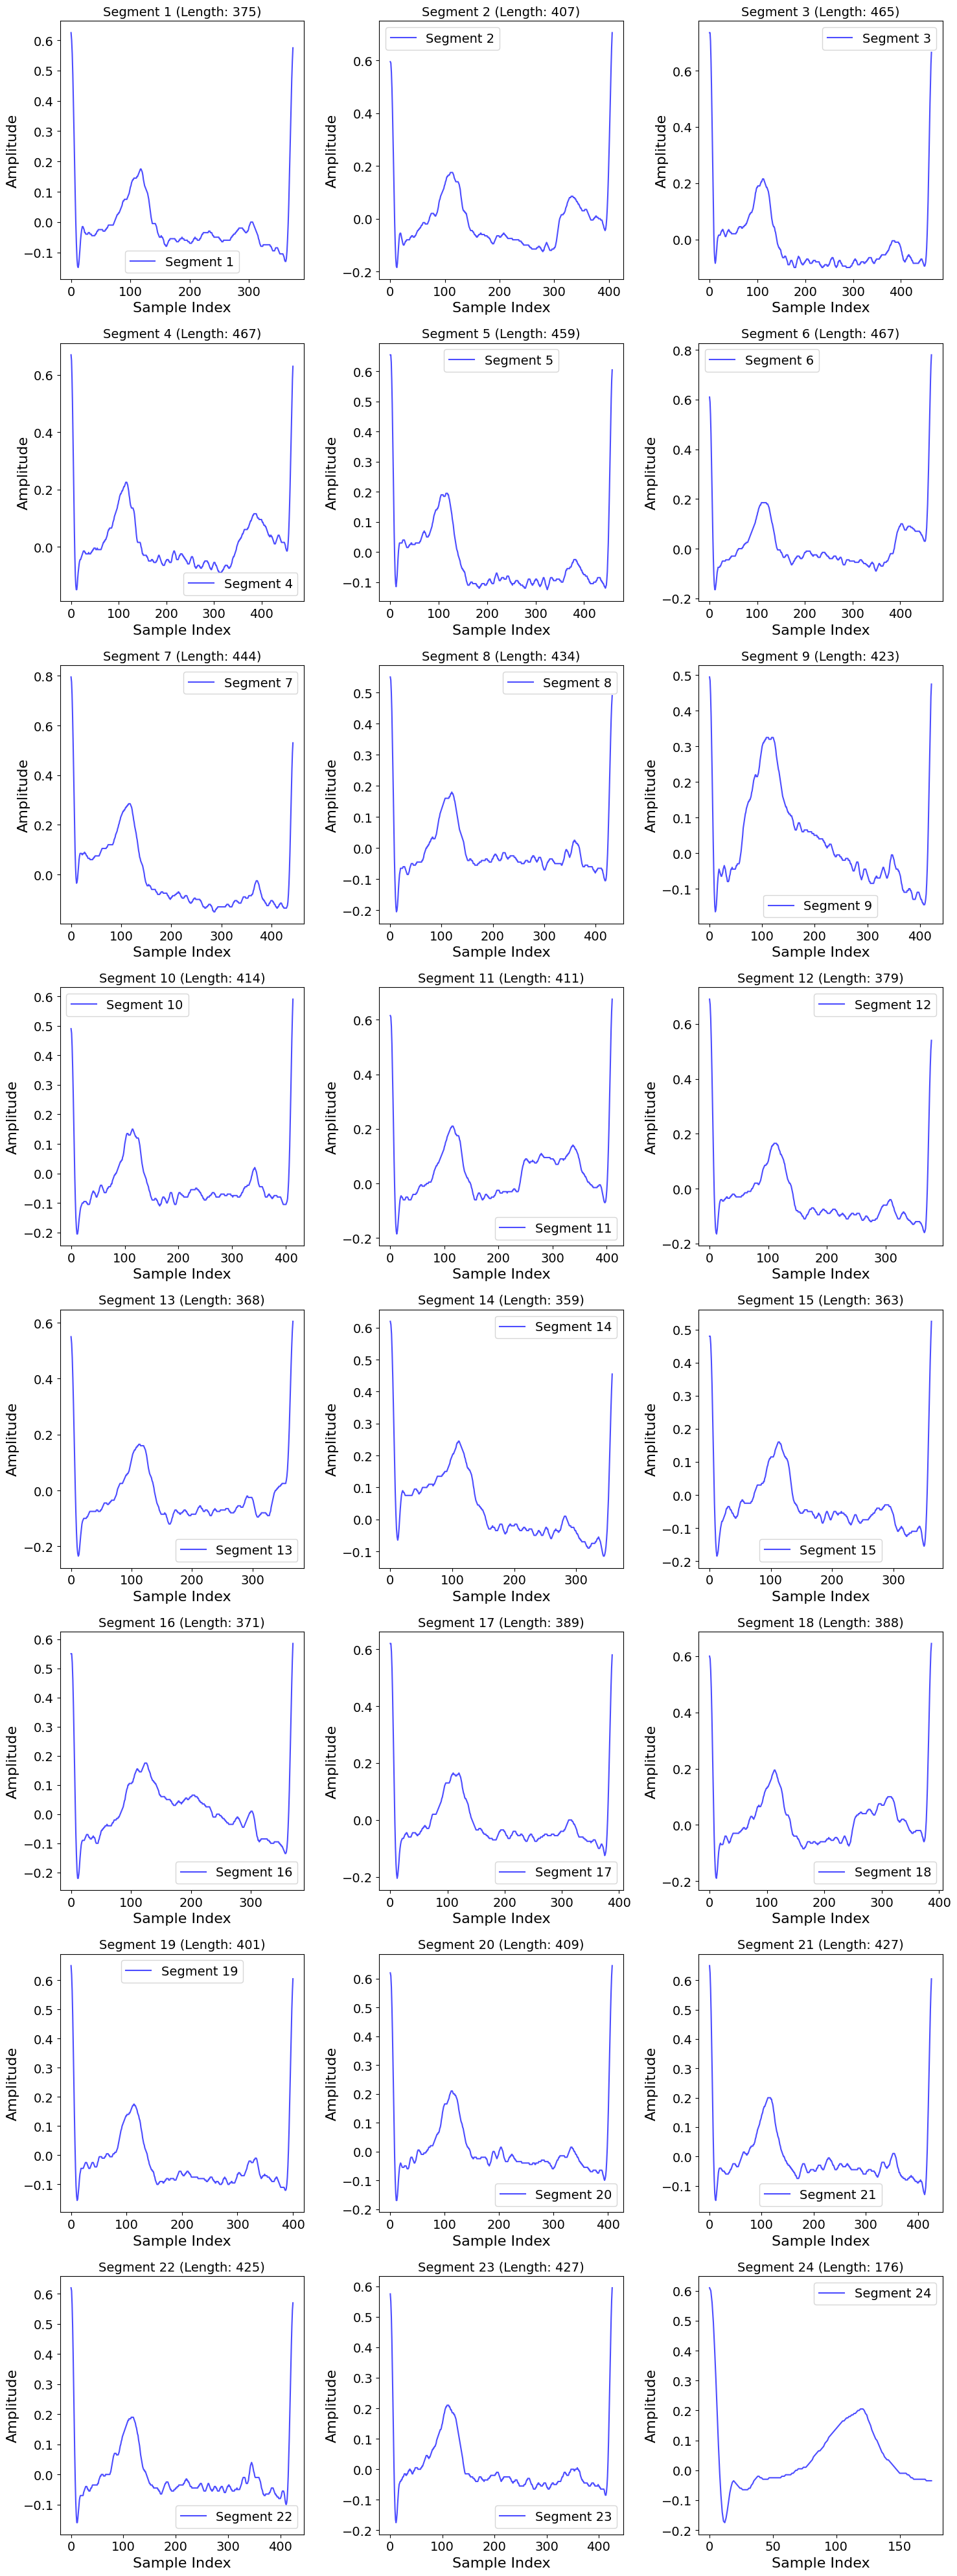

In [68]:
if __name__ == "__main__":
    # Получение данных записи для первого пути из списка record_pathes
    record = get_record(record_pathes[0])

    # Получение R-пиков из записи
    peaks = get_peaks(record)

    # Построение графика записи с отмеченными R-пиками
    plot_record(record, peaks)

    # Создание сегментов
    select_raw_segments, select_longest_segment_i, select_shortest_segment_i = select_segments(record, peaks)

    # Визуализация всех сегментов
    plot_segments(select_raw_segments)

    # Визуализируем все сегменты на одном графике с одинаковым масштабом
    plot_all_segments_same_scale(select_raw_segments)

    # Визуализация каждого сегмента по отдельности
    print("\nVisualizing all segments separately:")
    plot_segments_in_grid(select_raw_segments)

## Сегменты

In [69]:
# Функция для создания сегментов на основе записи и пиков
def create_segments(record, peaks):
    # Вычисление длины каждого сегмента между соседними пиками
    segment_lengths = [peaks[i + 1] - peaks[i] for i in range(len(peaks) - 2)]
    
    # Нахождение индексов самого длинного и самого короткого сегментов
    longest_segment_i, shortest_segment_i = np.argmax(segment_lengths), np.argmin(segment_lengths)
    
    # Определение длины самого длинного и самого короткого сегментов
    max_segment_length, min_segment_length = segment_lengths[longest_segment_i], segment_lengths[shortest_segment_i]

    raw_segments, normalized_segments = [], []  # Инициализация списков для сырых и нормализованных сегментов
    for i in range(len(peaks) - 2):
        # Добавление сырых сегментов в список
        raw_segments.append(record[peaks[i]:peaks[i + 1]])
        # Нормализация сегментов и добавление их в список нормализованных сегментов
        normalized_segments.append(normalize(record[peaks[i]:peaks[i] + max_segment_length]))

    # Возвращение списков сырых и нормализованных сегментов, а также индексов самого длинного и самого короткого сегментов
    return raw_segments, normalized_segments, longest_segment_i, shortest_segment_i


In [70]:
# Функция для построения графиков сегментов записи ЭКГ
def plot_segment(raw_shortest_segment, normalized_shortest_segment, raw_longest_segment, normalized_longest_segment):
    # Создание фигуры и осей для построения 4 графиков (2 строки и 2 столбца)
    fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(20, 20), frameon=False)
    fig.set_facecolor((0, 0, 0, 0))  # Установка прозрачного фона для фигуры
    fig.suptitle('Нормализация сегментов')  # Установка заголовка фигуры

    # Определение диапазона по оси X для нормализованного длинного сегмента
    xlim = len(normalized_longest_segment)
    # Настройка внешнего вида каждой оси
    for ay in axs:
        for ax in ay:
            ax.set_facecolor((0, 0, 0, 0))  # Установка прозрачного фона для оси

            ax.set_yticks([-1., .0, 1.])  # Настройка меток на оси Y
            ax.set_ylim([-1.0, 1.0])  # Установка диапазона оси Y

            ax.set_xticks([0, xlim // 2, xlim])  # Настройка меток на оси X
            ax.set_xlim([-50, xlim + 50])  # Установка диапазона оси X

            # Удаление рамок вокруг графика
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)

    # Определение размеров шрифтов для различных элементов графика
    SMALL_SIZE = 14
    MEDIUM_SIZE = 16
    BIGGER_SIZE = 32
    plt.rc('font', size=SMALL_SIZE)  # Размер шрифта для текста
    plt.rc('axes', titlesize=SMALL_SIZE)  # Размер шрифта для заголовков осей
    plt.rc('axes', labelsize=MEDIUM_SIZE)  # Размер шрифта для подписей осей
    plt.rc('xtick', labelsize=SMALL_SIZE)  # Размер шрифта для меток на оси X
    plt.rc('ytick', labelsize=SMALL_SIZE)  # Размер шрифта для меток на оси Y
    plt.rc('legend', fontsize=SMALL_SIZE)  # Размер шрифта для легенды
    plt.rc('figure', titlesize=BIGGER_SIZE)  # Размер шрифта для заголовка фигуры

    # Получение цветовой карты для графиков
    base_colors = plt.cm.get_cmap('Set2')

    # Настройка расстояний между графиками
    plt.subplots_adjust(wspace=0.25, hspace=0.25)

    # Построение графика необработанного кратчайшего сегмента
    axs[0][0].plot(raw_shortest_segment, color=base_colors.colors[2], label='Сигнал')
    axs[0][0].set_title('Необработанный кратчайший сегмент')  # Заголовок графика
    axs[0][0].set_xlabel('Время')  # Подпись для оси X
    axs[0][0].set_ylabel('Значение сигнала')  # Подпись для оси Y
    axs[0][0].axhline(linestyle='dashed', linewidth=1, color=base_colors.colors[0])

    # Построение графика нормализованного кратчайшего сегмента
    axs[0][1].plot(normalized_shortest_segment, color=base_colors.colors[2], label='Сигнал')
    axs[0][1].set_title('Нормализованный кратчайший сегмент')  # Заголовок графика
    axs[0][1].set_xlabel('Время')  # Подпись для оси X
    axs[0][1].set_ylabel('Значение сигнала')  # Подпись для оси Y
    axs[0][1].axhline(linestyle='dashed', linewidth=1, color=base_colors.colors[0])

    # Построение графика необработанного длиннейшего сегмента
    axs[1][0].plot(raw_longest_segment, color=base_colors.colors[2], label='Сигнал')
    axs[1][0].set_title('Необработанный длиннейший сегмент')  # Заголовок графика
    axs[1][0].set_xlabel('Время')  # Подпись для оси X
    axs[1][0].set_ylabel('Значение сигнала')  # Подпись для оси Y
    axs[1][0].axhline(linestyle='dashed', linewidth=1, color=base_colors.colors[0])

    # Построение графика нормализованного длиннейшего сегмента
    axs[1][1].plot(normalized_longest_segment, color=base_colors.colors[2], label='Сигнал')
    axs[1][1].set_title('Нормализованный длиннейший сегмент')  # Заголовок графика
    axs[1][1].set_xlabel('Время')  # Подпись для оси X
    axs[1][1].set_ylabel('Значение сигнала')  # Подпись для оси Y
    axs[1][1].axhline(linestyle='dashed', linewidth=1, color=base_colors.colors[0])

    # Добавление общей легенды для всех графиков
    handles, labels = plt.gca().get_legend_handles_labels()
    fig.legend(handles, labels, loc='center right')

    # Отображение графиков
    plt.show()


In [71]:
# Функция для нормализации сегмента сигнала
def normalize(segment: np.ndarray):
    # Определение масштаба, равного максимальному значению абсолютной амплитуды сегмента
    scale = max(np.abs(segment.max()), np.abs(segment.min()))

    # Возвращение нормализованного сегмента, разделенного на масштаб
    return segment / scale


C:\Users\user\AppData\Local\Temp\ipykernel_19460\2534276810.py:40: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  base_colors = plt.cm.get_cmap('Set2')


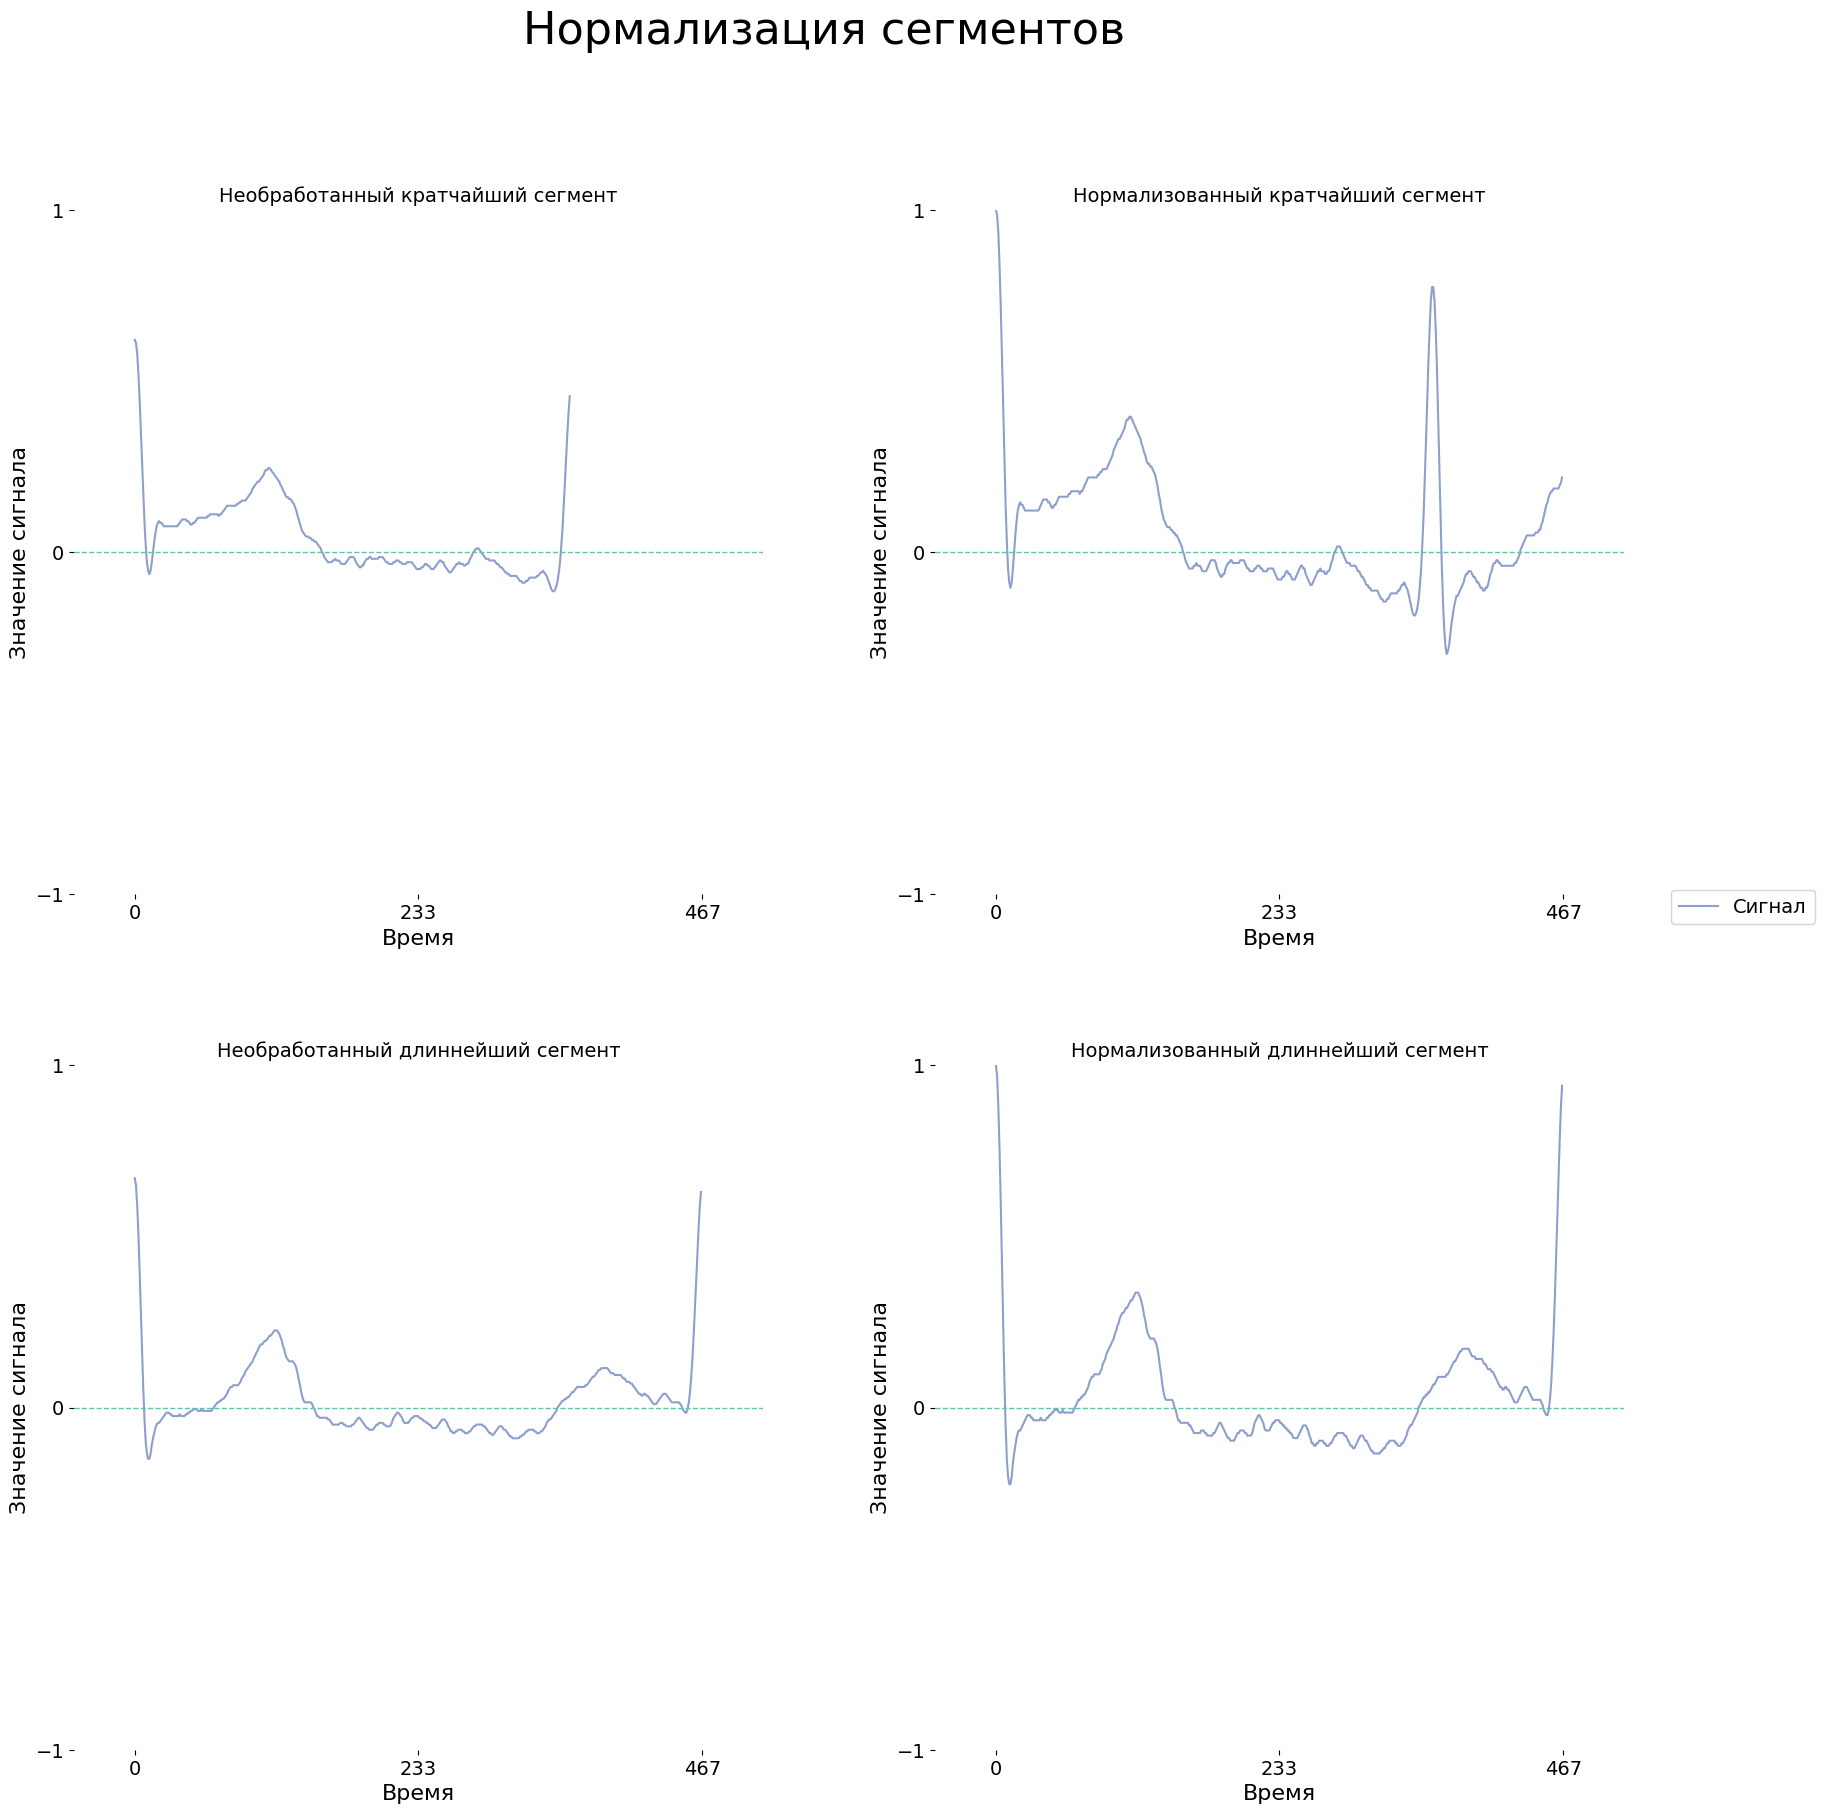

In [72]:
# Создание сегментов из записи и пиков
raw_segments, normalized_segments, longest_segment_i, shortest_segment_i = create_segments(record, peaks)

# Построение графиков для самых коротких и длинных сегментов
plot_segment(
    raw_shortest_segment=raw_segments[shortest_segment_i],
    normalized_shortest_segment=normalized_segments[shortest_segment_i],
    raw_longest_segment=raw_segments[longest_segment_i],
    normalized_longest_segment=normalized_segments[longest_segment_i],
)


## Извлечение признаков

In [73]:
# Функция для вычисления энтропии для сегмента сигнала
def entropy_for_segment(segment: np.ndarray):
    # Вычисление энтропии с помощью функции perm_entropy из библиотеки antropy
    return antropy.perm_entropy(segment.flatten())
    # Функция возвращает значение энтропии для выровненного сегмента


In [74]:
# Функция для вычисления числа переходов через ноль для сегмента сигнала
def zcr_for_segment(segment: np.ndarray):
    # Вычисление числа переходов через ноль с помощью функции num_zerocross из библиотеки antropy
    return antropy.num_zerocross(segment.flatten())
    # Функция возвращает значение числа переходов через ноль для выровненного сегмента


In [75]:
# Функция для вычисления кепстральных коэффициентов для сегмента сигнала
def cepstral_coefficients_for_segment(segment: np.ndarray):
    # Вычисление коэффициентов MFCC (Мел-кепстральных частот) с использованием функции mfcc из пользовательского модуля
    ceps, _, _ = mfcc(segment, nceps=12)  # nceps определяет количество коэффициентов

    # Возвращение второго коэффициента (индекс 1)
    return ceps[1]


In [76]:
# Инициализация пустого списка для хранения дескрипторов
descriptors = []

# Проход по каждому сегменту в списке нормализованных сегментов
for segment in normalized_segments:
    # Создание экземпляра класса Descriptor с параметрами: кепстральные коэффициенты, число переходов через ноль и энтропия
    desc = Descriptor(
        cepstral_coefficients=cepstral_coefficients_for_segment(segment),
        zcr=zcr_for_segment(segment),
        entropy=entropy_for_segment(segment),
    )
    # Добавление созданного дескриптора в список
    descriptors.append(desc)
    # Печать репрезентации дескриптора
    print(repr(desc))


-14.926, 5.520, 1.524, -0.431, -0.427, 0.175, 0.050, -0.028, 0.060, 0.113, 0.076, -0.157, 8.000, 1.477
-15.957, 4.571, 1.180, -0.450, 0.036, 0.660, 0.126, -0.075, 0.003, 0.401, 0.283, -0.033, 10.000, 1.653
-17.008, 3.298, 0.650, -0.853, -0.222, 0.540, 0.271, -0.173, -0.282, -0.150, 0.108, -0.043, 4.000, 1.534
-16.667, 3.844, 0.542, -0.861, -0.274, 0.527, 0.324, 0.065, 0.256, 0.549, 0.456, 0.013, 6.000, 1.543
-16.425, 3.259, 0.417, -0.926, -0.356, 0.517, 0.514, 0.244, 0.036, -0.025, 0.242, 0.124, 4.000, 1.676
-17.271, 3.334, 0.311, -0.661, -0.016, 0.377, 0.328, -0.376, 0.019, 0.286, 0.253, 0.280, 4.000, 1.372
-17.093, 3.441, 0.599, -0.567, -0.377, 0.212, 0.248, 0.082, 0.052, 0.212, 0.071, -0.061, 5.000, 1.563
-15.999, 3.791, 0.753, -0.635, -0.136, 0.526, 0.505, -0.069, -0.247, -0.112, 0.143, 0.095, 7.000, 1.585
-15.346, 3.684, 0.523, -0.676, -0.176, 0.542, 0.400, 0.242, -0.087, 0.122, 0.221, 0.011, 5.000, 1.674
-14.111, 2.926, 0.413, 0.170, 0.077, 0.194, 0.166, 0.110, 0.064, 0.100, 0.06

In [77]:
# Печать последнего созданного дескриптора
print(desc)


-------------------------------------------------------------------------------------------------------------------------
| Cepstral coefficients                                                                  | Zero crossing rate | Entropy |
-------------------------------------------------------------------------------------------------------------------------
| -16.202, 3.694, 0.575, -0.857, 0.020, 0.871, 0.676, 0.053, -0.135, 0.199, 0.282, 0.061 |                 11 |   1.551 |
-------------------------------------------------------------------------------------------------------------------------


## Создание данных для обучения
### Импорт моделей данных

In [102]:
# Импортирование класса Record из пользовательского модуля src.model.record
from model.record import Record

# Импортирование класса Descriptor из пользовательского модуля src.model.descriptor
from model.descriptor import Descriptor


### Дескрипторы с индексами персон

In [105]:
# Инициализация пустых списков для хранения дескрипторов и индексов
descriptors = []
idxs = []

# Проход по каждому пути пользователя в списке PERSON_PATHES
for i, person_path in enumerate(PERSON_PATHES):
    person_descriptors = []  # Инициализация пустого списка для дескрипторов конкретного пользователя

    # Получение путей к записям для текущего пользователя
    record_pathes = get_record_pathes(person_path)
    for record_path in record_pathes:
        # Создание объекта Record для текущего пути к записи
        record = Record(record_path)
        # Получение сегментов записи (длина не указана, нормализация не выполняется)
        record_segments = record.segments(length=None, normalize=False)

        # Проход по каждому сегменту записи
        for segment in record_segments:
            # Добавление дескриптора сегмента в общий список дескрипторов
            descriptors.append(
                Descriptor(
                    cepstral_coefficients=segment.cepstral_coeffs(),  # Вычисление кепстральных коэффициентов для сегмента
                    zcr=segment.zcr(),  # Вычисление числа переходов через ноль для сегмента
                    entropy=segment.entropy()  # Вычисление энтропии для сегмента
                ).as_array()  # Преобразование дескриптора в массив
            )
            # Добавление индекса текущего пользователя в список индексов
            idxs.append(i)


In [106]:
# Преобразование списка дескрипторов в массив NumPy с типом данных float
descriptors = np.array(descriptors, dtype=float)
# Преобразование списка индексов в массив NumPy с типом данных int и изменение формы массива
idxs = np.reshape(np.array(idxs, dtype=int), (len(idxs), 1))

# Печать формы массива дескрипторов
print(f'{descriptors.shape=}')
# Печать формы массива индексов
print(f'{idxs.shape=}')


descriptors.shape=(7054, 14)
idxs.shape=(7054, 1)


## Сохранение в CSV

In [107]:
# Импортирование библиотеки pandas для работы с данными в формате таблиц
import pandas as pd


In [108]:
# Создание списка имен столбцов для дескрипторов, включая 12 кепстральных коэффициентов, zcr и entropy
descriptor_column_names = [f'cc{str(i).zfill(2)}' for i in range(12)] + ['zcr', 'entropy']

# Создание DataFrame из массива дескрипторов с именами столбцов
descriptors_df = pd.DataFrame(data=descriptors, columns=descriptor_column_names)

# Создание DataFrame из массива индексов с именем столбца 'person_id'
idxs_df = pd.DataFrame(data=idxs, columns=['person_id'])


In [109]:
# Вывод первых 5 строк DataFrame с дескрипторами
descriptors_df.head(5)


,cc00,cc01,cc02,cc03,cc04,cc05,cc06,cc07,cc08,cc09,cc10,cc11,zcr,entropy
0,-15.056354,3.183778,0.406933,0.169705,0.382448,0.659126,0.436023,0.128087,0.089849,0.275935,0.333244,0.160213,6.0,1.495699
1,-15.207831,3.170253,0.432416,0.127589,0.288476,0.701308,0.629428,0.310780,0.138923,0.216081,0.271116,0.171169,8.0,1.642215
2,-14.819339,3.075317,0.435849,0.203273,0.300403,0.570054,0.487068,0.259030,0.181353,0.287371,0.320691,0.159191,4.0,1.531485
3,-14.891226,3.155517,0.358645,0.139645,0.296645,0.675883,0.563717,0.295737,0.116270,0.207529,0.247854,0.199679,6.0,1.543328
4,-15.077976,3.168169,0.594206,0.273458,0.215380,0.425614,0.401045,0.241007,0.185687,0.246903,0.343841,0.256724,4.0,1.662716


In [111]:
# Вывод первых 5 строк DataFrame с индексами
idxs_df.head(5)


,person_id
0,0
1,0
2,0
3,0
4,0


In [112]:
# Сохранение DataFrame с дескрипторами в CSV файл
descriptors_df.to_csv(
    path_or_buf=os.path.abspath(os.path.join(DATASET_PATH, 'descriptors.csv')),  # Путь к файлу
    index=False,  # Отключение индексации
)

# Сохранение DataFrame с индексами в CSV файл
idxs_df.to_csv(
    path_or_buf=os.path.abspath(os.path.join(DATASET_PATH, 'labels.csv')),  # Путь к файлу
    index=False,  # Отключение индексации
)

# Описание и анализ данных

In [113]:
import pandas as pd

# Пути к CSV-файлам
descriptors_path = '../dataset/descriptors.csv'
labels_path = '../dataset/labels.csv'

# Загрузка данных
descriptors_df = pd.read_csv(descriptors_path)  # Заголовки есть
labels_df = pd.read_csv(labels_path)           # Заголовки есть

# Преобразование в массивы NumPy
descriptors = descriptors_df.values  # Все строки как дескрипторы
labels = labels_df.values.flatten()  # Преобразуем в одномерный массив

# Проверка размерностей
print("Размерность descriptors:", descriptors.shape)
print("Размерность labels:", labels.shape)

Размерность descriptors: (7054, 14)
Размерность labels: (7054,)


In [114]:
# Проверка соответствия размеров
assert len(descriptors) == len(labels), "Количество дескрипторов и меток не совпадает!"

# Вывод первых нескольких примеров
print("Первые 5 дескрипторов:")
print(descriptors[:5])

print("Первые 5 меток:")
print(labels[:5])

Первые 5 дескрипторов:
[[-15.05635359   3.18377783   0.40693318   0.16970534   0.382448
    0.65912612   0.43602274   0.12808732   0.08984883   0.27593474
    0.33324355   0.1602132    6.           1.49569918]
 [-15.20783084   3.1702528    0.43241625   0.12758879   0.28847605
    0.70130807   0.62942821   0.31077991   0.138923     0.21608145
    0.27111553   0.17116877   8.           1.64221476]
 [-14.81933931   3.07531718   0.43584942   0.20327274   0.30040279
    0.57005385   0.48706798   0.25903016   0.18135327   0.28737074
    0.32069054   0.15919145   4.           1.53148547]
 [-14.89122583   3.15551698   0.35864497   0.13964505   0.29664462
    0.67588341   0.56371681   0.29573742   0.11627015   0.20752869
    0.24785449   0.19967932   6.           1.5433283 ]
 [-15.07797649   3.16816886   0.59420564   0.27345838   0.21538002
    0.42561433   0.40104454   0.24100711   0.185687     0.2469034
    0.34384088   0.2567241    4.           1.66271577]]
Первые 5 меток:
[0 0 0 0 0]


In [115]:
from collections import defaultdict

# Создаем словарь для хранения данных по классам
class_data = defaultdict(list)

for descriptor, label in zip(descriptors, labels):
    class_data[label].append(descriptor)

# Проверка количества примеров для каждого класса
for label, data in class_data.items():
    print(f"Класс {label}: {len(data)} примеров")

Класс 0: 463 примеров
Класс 1: 516 примеров
Класс 2: 110 примеров
Класс 3: 44 примеров
Класс 4: 34 примеров
Класс 5: 44 примеров
Класс 6: 43 примеров
Класс 7: 55 примеров
Класс 8: 131 примеров
Класс 9: 130 примеров
Класс 10: 69 примеров
Класс 11: 55 примеров
Класс 12: 17 примеров
Класс 13: 44 примеров
Класс 14: 24 примеров
Класс 15: 86 примеров
Класс 16: 41 примеров
Класс 17: 44 примеров
Класс 18: 52 примеров
Класс 19: 35 примеров
Класс 20: 71 примеров
Класс 21: 43 примеров
Класс 22: 35 примеров
Класс 23: 86 примеров
Класс 24: 87 примеров
Класс 25: 67 примеров
Класс 26: 48 примеров
Класс 27: 91 примеров
Класс 28: 52 примеров
Класс 29: 98 примеров
Класс 30: 57 примеров
Класс 31: 103 примеров
Класс 32: 48 примеров
Класс 33: 137 примеров
Класс 34: 123 примеров
Класс 35: 101 примеров
Класс 36: 44 примеров
Класс 37: 38 примеров
Класс 38: 37 примеров
Класс 39: 102 примеров
Класс 40: 41 примеров
Класс 41: 102 примеров
Класс 42: 39 примеров
Класс 43: 24 примеров
Класс 44: 52 примеров
Класс 45:

Распределение записей по классам:
person_id
0     463
1     516
2     110
3      44
4      34
     ... 
85     58
86     53
87     65
88     39
89     31
Name: count, Length: 90, dtype: int64


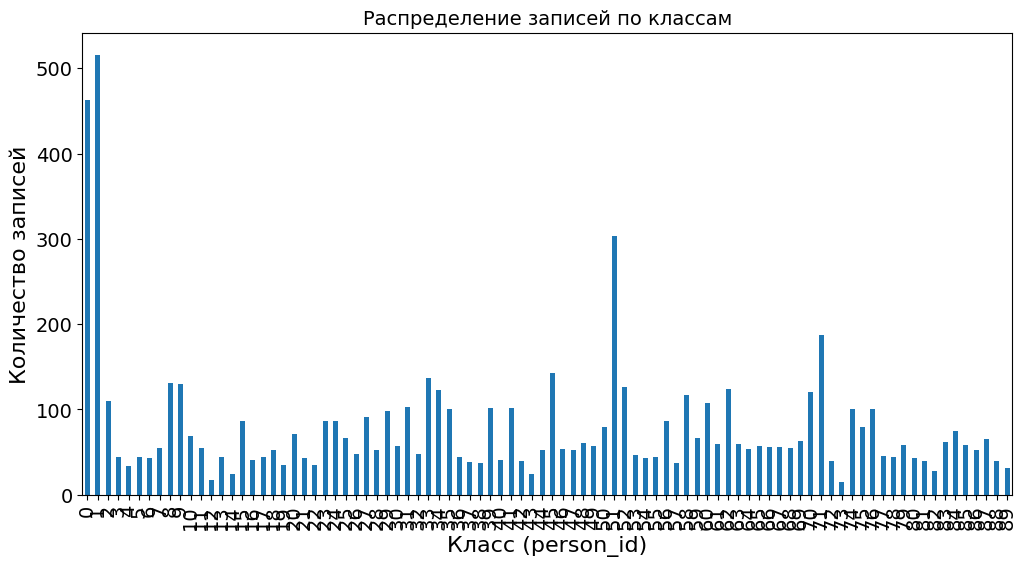

In [ ]:
import pandas as pd

# Загрузка меток
labels = pd.read_csv('../dataset/labels.csv')

# Подсчёт количества записей для каждого класса
class_distribution = labels['person_id'].value_counts().sort_index()
print("Распределение записей по классам:")
print(class_distribution)

# Визуализация распределения
import matplotlib.pyplot as plt

class_distribution.plot(kind='bar', figsize=(12, 6), title='Распределение записей (сегментов) по классам')
plt.xlabel('Класс (person_id)')
plt.ylabel('Количество записей (сегментов)')
plt.show()